# Importing Library

In [1]:
import numpy as np
import pandas as pd
import random
import operator
import pandas as pd
import matplotlib.pyplot as plt
import re
from geopy import distance
import time
import math

# Function and Object

## Simulation

### Function

#### Reading and Preprocessing Data

In [2]:
def read_excel(data):
    df = pd.read_excel('Data Prep.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

def read_excel_revisi(data):
    df = pd.read_excel('Data Prep Revisi.xlsx', index_col=0, sheet_name=data)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df



def mirroring(df): 
    df_c = df.copy()
    df = df.fillna(0)
    df = df + df.T
    df[df_c.isnull() & (df == 0)] = None
    return df

def set_same_zero(df):
    df_column = df.columns.values
    df_column = set(df_column)
    df_index = df.index.values
    df_index = set(df_index)
    same_port = df_index & df_column

    # making same port data into 0 
    for i in same_port:
        df[i][i]=0
    return df

def calculate_availibility(wave_status):
    wave_status['PR_availability'] = wave_status['wave_h']<2
    return wave_status

In [3]:
def fill_mean(df):
    df = df.fillna(df.mean().mean())
    return df

#### Coordinate Data

In [4]:
#CONVERT DMS TO DECIMAL
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd;

def dd2dms(deg):
    d = int(deg)
    md = abs(deg - d) * 60
    m = int(md)
    sd = (md - m) * 60
    return [d, m, sd]

def parse_dms(dms):
    parts = re.split('[°\'"]+', dms)
    lat = dms2dd(parts[0], parts[1], parts[2], parts[3])
    return lat

#### Choosing and making port

In [5]:
def quickport(port_name):
    name = ports[ports['port'] == port_name]['port'].values[0]
    port_type = ports[ports['port'] == port_name]['port_type'].values[0]
    return Port(name,port_type)

In [6]:
def chooseport(port_name):
    port_name = port_name.rstrip()
    port_name = port_name.lstrip()
    return ports[ports['port'] == port_name]['port_object'].iloc[0]

In [7]:
def chooseship(ship_name):
    ship_name = ship_name.rstrip()
    ship_name = ship_name.lstrip()
    return ship_df[ship_df['Ship_Name'] == ship_name]['object'].iloc[0]

In [8]:
def add_TL_route(route):
    finished = False
    i = 0
    while finished == False:
        current_item = route[i]
        if current_item.name in ['Ambon','Saumlaki','Tual']:
            k=0
            for j in movable_TL[current_item.name]:
                k+=1
                route.insert(i+k,j)
            i+=len(movable_TL[current_item.name])
        i+=1
        if len(route) <= i:
            break
    return route

In [9]:
def port_items(port):
    global all_port_item
    item_list = all_port_item[all_port_item['Pelabuhan'] == port]
    return item_list

In [10]:
def find_distance(port_a,port_b):
#     print(port_a)
#     print(port_b)
    a = port_loc[port_loc['Nama Pelabuhan'] == port_a]
    b = port_loc[port_loc['Nama Pelabuhan'] == port_b]
#     print(a)
#     print(b)
#     print(a['Lat_decimal'].values[0])
#     print(a['Long_decimal'].values[0])
#     print(b['Lat_decimal'].values[0])
#     print(b['Long_decimal'].values[0])
    dist = distance.distance((a['Lat_decimal'].values[0],a['Long_decimal'].values[0]),(b['Lat_decimal'].values[0],b['Long_decimal'].values[0])).miles
    return dist

In [11]:
def choose_char(ship_type):
    global TL_char, PL_char, PR_char
    if ship_type=='TL':
        ship_char = TL_char
    elif ship_type=='PL':
        ship_char = PL_char
    elif ship_type=='PR':
        ship_char = PR_char
    return ship_char

In [12]:
def per_item_revenue(data):
#     distance = find_distance(data['Pelabuhan'],data['Tujuan Pelabuhan'])
    distance = data['Jarak']
    Bobot = data['Bobot']
    BJT = biaya_jarak_teus[data['Pelabuhan']][data['Tujuan Pelabuhan']]
#     BJT = biaya_jarak_teus[data['Pelabuhan Asal']][data['Tujuan Pelabuhan']]
    income = distance*Bobot*BJT
    return income

In [13]:
def port_revenue(storage_df):
    total_income = 0
    global gl, gli
    gl = storage_df
    for i in storage_df.index:
        gli = i
        income = per_item_revenue(storage_df.loc[i])
        total_income += income
    return total_income

In [14]:
def item_left(df):
    return int(df['Bobot'].sum())

In [15]:
def find_movable_port(ship_type,port_name):
    if ship_type == 'TL':
        flag = False
    elif ship_type == 'PR':
        flag = True
    else:
        added_route = []
        return added_route
    r_list = special_PR[port_name].dropna().to_list()
    route_list = wave_status[wave_status['Port'].isin(r_list)][wave_status['PR_availability'] == flag]['Port'].to_list()
    added_route = []
    for i in route_list:
        added_route.append(chooseport(i))
    return added_route

In [16]:
def all_item(available_ship,ports):
    itemdf = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
    itemdf.index.name = 'code barang'
    for i in ports['port_object']:
        itemdf = itemdf.append(i.demand)
    for i in available_ship:
        itemdf = itemdf.append(i.storage)
    return itemdf

In [17]:
def create_route(route_list):
    route = []
    for i in route_list:
        route.append(chooseport(i))
    return route
    

In [18]:
def total_revenue(available_ship):
    total_revenue = 0
    for i in available_ship:
        total_revenue += i.revenue
    return total_revenue

In [19]:
def get_route(df):
    return df['Route'].to_list()

In [20]:
def create_ship_df(excel = 'Data Ship.xlsx'):
    x1 = pd.ExcelFile(excel)
    names = x1.sheet_names
    ship_df = pd.DataFrame()
    for i in names:
        ship_data = x1.parse(i)
        port_list = create_route(get_route(ship_data))
        this_ship_df = pd.DataFrame(data = {'Ship_Name': [ship_data['Ship_Name'].iloc[0]],
                                           'Ship_Type': [ship_data['Ship_Type'].iloc[0]],
                                           'original_port': [ship_data['original_port'].iloc[0]],
                                            'object':[Ship(ship_data['Ship_Type'].iloc[0],
                                                             route = port_list,
                                                             name=ship_data['Ship_Name'].iloc[0],
                                                             initial_port = ship_data['original_port'].iloc[0])]
                                           })
        ship_df = ship_df.append(this_ship_df)

    ship_df = ship_df.reset_index(drop=True)
    return ship_df

In [21]:
def adjust_wave():
    global wave_status,route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,movable_TL
    wave_status['wave_h'] = wave_status['wave_h'].apply(lambda x: random.random()*4)
    wave_status = calculate_availibility(wave_status)
    movable_TL = {'Ambon' : find_movable_port('TL','Ambon'),
              'Tual' : find_movable_port('TL','Tual'),
              'Saumlaki' : find_movable_port('TL','Saumlaki')}
    route_PR_Ambon = [chooseport('Ambon')]+find_movable_port('PR','Ambon')
    route_PR_Tual = [chooseport('Tual')]+find_movable_port('PR','Tual')
    route_PR_Saumlaki = [chooseport('Saumlaki')]+find_movable_port('PR','Saumlaki')



In [22]:
def shuffle_route(available_ship):
    for i in available_ship:
        random.shuffle(i.route)

In [23]:
def initial_port_to_first(available_ship):
    for i in available_ship:
        init_index = i.route.index(i.initial_port)
        intial_port_to_front = i.route.pop(init_index)
        i.route.insert(0, intial_port_to_front)

In [24]:
def redefine_route():
    global route_PR_Ambon,route_PR_Tual,route_PR_Saumlaki,ship_df
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Ambon']['object'].iloc[0].route = route_PR_Ambon
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Tual']['object'].iloc[0].route = route_PR_Tual
    ship_df[ship_df['Ship_Type'] == 'PR'][ship_df['original_port'] == 'Saumlaki']['object'].iloc[0].route = route_PR_Saumlaki

    for i in ship_df[ship_df['Ship_Type'] == 'TL']['object'].to_list():
        i.route =  add_TL_route(i.route)
        
                

In [25]:
def port_sequence(ship):
    if ship.destination_dist<=ship.current_dist:
        ship.move_port()
#         print('')
#         print('')
#         print('')
#         print('')
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('ship_type: '+ship.ship_type)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
#         print('BEFORE')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
        ship.move_storage()
#         print('oOoOoOoOoOoOoOoOoOoOoOoO')
#         print('AFTER')
#         print('current port:' + ship.current_port.name)
#         print('')
#         print('PORT DEMAND:')
#         print(ship.current_port.demand)
#         print('')
#         print('SHIP STORAGE:')
#         print(ship.storage)
#         print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$')
        ship.find_destination()
        ship.destination_dist = find_distance(ship.destination.name, ship.current_port.name)
        ship.current_dist = 0
    elif ship.destination_dist>ship.current_dist:
        ship.storage['Jarak'] = ship.storage['Jarak']+ship.speed
        ship.current_dist+=ship.speed

        


In [26]:
def run_simulation():
    new_port_item = all_item(available_ship,ports)
    remaining = item_left(new_port_item)
    i=0
    remaining_history = []
    revenue_history = []
    tic = time.clock()
    while remaining>0:
        i +=1
        for ship in available_ship:
            port_sequence(ship)
        new_port_item = all_item(available_ship,ports)
        remaining = item_left(new_port_item)
        revenue = total_revenue(available_ship)
        print('************************************************')
        print('revenue: {}'.format(revenue))
        print('remaining: ' + str(remaining))
        print('iteration: ' + str(i))
        print('************************************************')
        remaining_history.append(remaining)
        revenue_history.append(revenue)
        if i>=7000:
            break
    toc = time.clock()
    process_time = toc-tic
    return remaining_history,revenue_history,process_time


In [27]:
def analyse_simulation(remaining_history,revenue_history):
    plt.plot(remaining_history)
    plt.show()
    plt.plot(revenue_history)
    plt.show()
    print('Total Revenue: {}'.format(revenue_history[-1]))

In [28]:
def create_ports_object(ports):
    ports['port_object'] = ports['port'].apply(lambda x: quickport(x))
    return ports

In [29]:
def refill_ports(ports):
    for i in ports['port_object'].to_list():
        i.demand = port_items(i.name)

In [30]:
def reset_revenue(available_ship):
    for i in available_ship:
        i.revenue = 0
    return available_ship

### CLASSES

In [31]:
class Port:
    def __init__(self, name,port_type):
        self.name = name
        self.port_type = port_type
        self.demand = port_items(name)
        
    
    def __repr__(self):
        if self.port_type == 'U':
            port_type_name = 'Utama'
        elif self.port_type == 'P':
            port_type_name = 'Pengumpul'
        elif self.port_type == 'R':
            port_type_name = 'Pengumpan'
        else:
            port_type_name = 'NOT DEFINED'

        return port_type_name + ":" + self.name
    

In [32]:
class Ship:
    def __init__(self, ship_type, route=[], name='No Name',initial_port = False,time_skip = 6):
        self.name = name
        self.ship_type = ship_type
        self.revenue = 0
        self.route = route
        self.current_port = route[0]
        self.destination = route[0]
        if initial_port == False:
            self.initial_port = route[0]
        else:
            self.initial_port = chooseport(initial_port)
            
        self.port_cycle = route
        self.route_list = []
        self.ship_char = choose_char(self.ship_type)
        self.destination_dist = 0
        self.current_dist = 1000
        self.speed = self.ship_char['ship_char']['V']*time_skip
        self.max = self.ship_char['ship_char']['max_voyage']/(24/time_skip)
        for i in route:
            self.route_list.append(i.name)

        storage_df = pd.DataFrame(columns = ['Pelabuhan','Bobot','Tujuan Pelabuhan','Jarak'])
        storage_df.index.name = 'code barang'
        self.storage = storage_df
        self.storage_volume = storage_df['Bobot'].sum()
        
        #Capacity
        self.capacity = self.ship_char['ship_char']['VC']
        
        
        #special route for TL depending on wave height
        if self.ship_type == 'TL':
            self.TL_Special_PR = list(set(route).intersection(set(special_PR.columns))) #TODO : CHECK PR NOT IN AND IN BASED ON WAVE
            portcycle_name =[]
            for i in self.port_cycle:
                portcycle_name.append(i.name)
            P_port_PR_transitport =  list(set(portcycle_name).intersection(set(special_PR.columns)))
            P_port_non_PR_transitport = [x for x in special_PR.columns if x not in P_port_PR_transitport]
            
            self.PR_transitport = []
            self.non_PR_transitport = []

            for i in P_port_PR_transitport:
                self.PR_transitport.extend(special_PR[i].dropna().to_list())
            for i in P_port_non_PR_transitport:
                self.non_PR_transitport.extend(special_PR[i].dropna().to_list())

    def update_storage_volume(self):
        self.storage_volume = self.storage['Bobot'].sum()

    def cycle_list(self):
        self.port_cycle = list(self.port_cycle[1:])+[self.port_cycle[0]]

    def find_destination(self):
        pick_item = False

        i = 0
        while pick_item == False:
            if i < len(self.port_cycle):
                pick_item = self.simulate_moving()
                if pick_item == False:
                    self.cycle_list()
            else:
                return
            i += 1
        self.cycle_list()
        self.destination = self.port_cycle[0]
        return self.destination
    
    def move_port(self):
        self.current_port = self.port_cycle[0]

    def cost_per_item(self,item ):
        Bobot = item['Bobot']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        C_bm = self.ship_char[self.current_port.name ]['C_bm']
        inventory_cost = self.ship_char[self.current_port.name ]['inventory_cost']
        bm_time = self.ship_char[self.current_port.name ]['bm_time']
        avg_docking_time = self.ship_char[self.current_port.name ]['avg_docking_time']
#         distance = find_distance(item['Pelabuhan'],self.current_port.name )
        distance = item['Jarak']
        V = self.ship_char['ship_char']['V']
        VC = self.ship_char['ship_char']['VC']
        port_storage_time = self.ship_char[self.current_port.name ]['port_storage_time']
        C_storage = self.ship_char[self.current_port.name ]['C_storage']

        total_cost_bongkar = Bobot*bm_time*C_bm
        total_cost_storage = Bobot * port_storage_time * C_storage
        total_cost_travel_time = inventory_cost*bm_time*(avg_docking_time*(distance/V))
        cost_bongkar_time = inventory_cost * (Bobot/C_bm)

        travel_cost = total_cost_bongkar + total_cost_storage+total_cost_travel_time+cost_bongkar_time
        
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')        
#         print('item: '+str(item))
#         print('bm time:'+str(bm_time))
#         print('C_bm:'+str(C_bm))
#         print('inventory_cost:'+str(inventory_cost))
#         print('bm_time:'+str(bm_time))
#         print('avg_docking_time:'+str(avg_docking_time))
#         print('distance:'+str(distance))
#         print('V:'+str(V))
#         print('VC:'+str(VC))
#         print('port_storage_time:'+str(port_storage_time))
#         print('C_storage:'+str(C_storage))
#         print('bongkar: {} storage: {} travelT: {} btime: {}'.format(total_cost_bongkar,total_cost_storage,total_cost_travel_time,cost_bongkar_time))
#         print('&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&&')
        
        return travel_cost, [total_cost_bongkar, total_cost_storage, total_cost_travel_time, cost_bongkar_time]
    
    def drop_off_item(self,tujuan_pelabuhan,finish_shipping = True):
        ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.storage = pd.concat([self.storage, ship_item]).drop_duplicates(keep=False)
        
        if finish_shipping == False:
            ship_item['Pelabuhan'] = self.current_port.name
            self.current_port.demand = self.current_port.demand.append(ship_item)
#         elif finish_shipping == True:
#             self.revenue += port_revenue(ship_item)
        
        #CALCULATING SHIP COST        
        total_cost_bongkar = 0
        total_cost_storage = 0
        total_cost_travel_time = 0
        cost_bongkar_time = 0
        travel_cost = 0
        for i in list(ship_item.index):
            item = ship_item.loc[i]
            travel_cost,_ = self.cost_per_item(item)
        self.revenue -= travel_cost
        self.revenue += port_revenue(ship_item)

        self.update_storage_volume()
            
        return ship_item
    
    def pick_up_each(self,port_item):
        for i in port_item.index:
            current_port_item = port_item.loc[i]
            bobot_item = current_port_item['Bobot']
            if (self.storage_volume + bobot_item)<=self.capacity:
                bobot_item_df = pd.DataFrame(current_port_item).T
                self.current_port.demand = pd.concat([self.current_port.demand, bobot_item_df]).drop_duplicates(keep=False)
                bobot_item_df['Jarak'] = 0
                self.storage = self.storage.append(bobot_item_df)
                self.update_storage_volume()    
    
    def pick_up_port(self,tujuan_pelabuhan):
        port_item = self.current_port.demand[self.current_port.demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
        self.pick_up_each(port_item)

    def check_item(self,tujuan_pelabuhan,pick_or_drop,pick_item=False):
        if pick_item == True:
            return pick_item
        else:
            if pick_or_drop == 'drop':
                ship_item = self.storage[self.storage['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(ship_item.empty)
            elif pick_or_drop == 'pick':
                port_item = self.port_cycle[1].demand[self.port_cycle[1].demand['Tujuan Pelabuhan'] == tujuan_pelabuhan]
                pick_item = not(port_item.empty)
            return pick_item
    
    def simulate_moving(self):
        # ITEM DROP OFF--------------------------------------------------------
        simulated_port = self.port_cycle[1]
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        pick_item = False
        pick_item = self.check_item(simulated_port.name,'drop',pick_item=pick_item)

        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if simulated_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
        

        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:            
            #FOR TL
            if self.ship_type == 'TL':
                pick_item = self.check_item('Tanjung Priok','drop',pick_item=pick_item)
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in P_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
                for i in U_non_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)

       #for Special PR (Ambon, Tual, and Saumlaki)
        if simulated_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[simulated_port.name].dropna().to_list()                
                for i in current_port_R_ports:
                    pick_item = self.check_item(i,'drop',pick_item=pick_item)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',simulated_port.name)
                for i in current_r:
                    pick_item = self.check_item(i.name,'drop',pick_item=pick_item)
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            pick_item = self.check_item(i.name,'pick',pick_item=pick_item)

        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.check_item('Tanjung Priok','pick',pick_item=pick_item)
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if simulated_port.name not in special_PR.columns:
                for i in R_list:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                if pick_item == True:
                    pass
                else:
                    pick_item = not(port_item.empty)
                    
#         P not in special P
        if ((simulated_port.port_type == 'P') and (simulated_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)


        #for Tanjung Priok
        if simulated_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = simulated_port.demand
                pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            
        #for Tanjung Perak and Makassar
        if simulated_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        pick_item = self.check_item(j,'pick',pick_item=pick_item)     
            elif self.ship_type == 'PL':
                pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for Special PR
        if simulated_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',simulated_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(simulated_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',simulated_port.name)
                for i in port_PR_ports:
                    pick_item = self.check_item(i,'pick',pick_item=pick_item)

        #for R
        if simulated_port.name in R_list+['Banda Neira']:
            port_item = simulated_port.demand
            pick_item = self.check_item(i,'pick',pick_item=pick_item) #TODO 

            if pick_item == True:
                pass
            else:
                pick_item = not(port_item.empty)

            
        # ITEM PICK UP--------------------------------------------------------
        return pick_item
    
    def move_storage(self):
        # ITEM DROP OFF--------------------------------------------------------
        
        # ALL ITEM WITH PORT DESTINATION AT CURRENT PORT
        self.drop_off_item(self.current_port.name)
        
        #SPECIAL DROP OFF ITEM
        #FOR PR
        if self.ship_type == 'PR':
            if self.current_port.name not in R_list:
                for i in ports[~ports['port'].isin(self.route)]['port'].to_list():
                    self.drop_off_item(i,finish_shipping = False)
        
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            
            #FOR TL
            if self.ship_type == 'TL':
                self.drop_off_item('Tanjung Priok',finish_shipping = False )
                P_non_in_route = [x for x in ports[ports['port_type'] == 'P']['port'].to_list() if x not in self.route]
                U_non_in_route = [x for x in ports[ports['port_type'] == 'U']['port'].to_list() if x not in self.route]
                for i in self.non_PR_transitport:
                    self.drop_off_item(i,finish_shipping = False )
                for i in P_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)
                for i in U_non_in_route:
                    self.drop_off_item(i,finish_shipping = False)

            #FOR PL
            elif self.ship_type == 'PL':
                not_in_route = [x for x in ports['port'].to_list() if x not in self.route]
                for i in not_in_route:
                    self.drop_off_item(i,finish_shipping = False )

       #for Special PR (Ambon, Tual, and Saumlaki)
        if self.current_port.name in special_PR.columns:
            #FOR PL
            if self.ship_type == 'PL':
                current_port_R_ports = special_PR[self.current_port.name].dropna().to_list() 
                for i in current_port_R_ports:
                    self.drop_off_item(i.strip(),finish_shipping = False)
            #FOR TL
            elif self.ship_type == 'TL':
                current_r = find_movable_port('PR',self.current_port.name)
                for i in current_r:
                    self.drop_off_item(i.name,finish_shipping = False)
                    
        self.current_port.demand = self.current_port.demand.loc[~self.current_port.demand.index.duplicated(keep='first')]
        # ITEM DROP OFF--------------------------------------------------------

        
        
        
        # ITEM PICK UP--------------------------------------------------------
        
        #PICK UP IN PORT CYCLE
        for i in self.port_cycle:
            self.pick_up_port(i.name)
        
        #Take for Tanjung Priok
        if self.ship_type == 'TL':
            if self.current_port.name not in ['Tanjung Perak','Makassar']:
                self.pick_up_port('Tanjung Priok')
        if self.ship_type == 'PR':
            if self.current_port.name not in special_PR.columns:
                self.pick_up_port('Tanjung Priok')
            
        #SPECIAL FOR PL SHIP: 
        if self.ship_type == 'PL':
            #TAKE EVERYTHING with TANJUNG PRIOK
            self.pick_up_port('Tanjung Priok')
            if self.current_port.name not in special_PR.columns:
                for i in R_list:
                    self.pick_up_port(i)
                    
            #TAKE EVERYTHING in BANDA NEIRA
            if self.current_port.name == 'Banda Neira':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)   
                
#         P not in special P
        if ((self.current_port.port_type == 'P') and (self.current_port.name not in special_PR.columns)):
            if self.ship_type == 'TL':
                for i in self.PR_transitport:
                    self.pick_up_port(i)


        #for Tanjung Priok
        if self.current_port.name == 'Tanjung Priok':
            if self.ship_type == 'PL':
                port_item = self.current_port.demand
                self.pick_up_each(port_item)
                
            
        #for Tanjung Perak and Makassar
        if self.current_port.name in ['Tanjung Perak','Makassar']:
            #FOR TL
            if self.ship_type == 'TL':
                for i in list(set(special_PR.columns) & set(self.route_list)):
                    i_r_list = find_movable_port(self.ship_type,i)
                    for j in i_r_list:
                        self.pick_up_port(j)     
            elif self.ship_type == 'PL':
                self.pick_up_port('Tanjung Priok')

        #for Special PR
        if self.current_port.name in special_PR.columns:
            #FOR TL
            if self.ship_type == 'TL':
                port_PR_ports = find_movable_port('TL',self.current_port.name)
                special_pr_ports_list = special_PR.columns.to_list()
                special_pr_ports_list.remove(self.current_port.name)
                other_r_list = []
                for i in special_pr_ports_list:
                    other_r_list.extend(special_PR[i].dropna().to_list())
                port_PR_ports.extend(other_r_list)
                for i in port_PR_ports:
                    self.pick_up_port(i)
                
            #FOR PR
            elif self.ship_type == 'PR':
                port_PR_ports = find_movable_port('PR',self.current_port.name)
                for i in port_PR_ports:
                    self.pick_up_port(i)

        #for R
        if self.current_port.name in R_list+['Banda Neira']:
            port_item = self.current_port.demand
            self.pick_up_each(port_item)

        self.storage = self.storage.loc[~self.storage.index.duplicated(keep='first')]
        self.storage['Jarak'] = self.storage['Jarak'].fillna(0)

        # ITEM PICK UP--------------------------------------------------------
      
    
    
    
    def __repr__(self):
        return self.name +': '+ self.ship_type

# CODE PART

## Reading Data

### Basic Characteristic Data

In [33]:
TL_char = read_excel_revisi('TL_char')
PL_char = read_excel_revisi('PL_char')
PR_char = read_excel_revisi('PR_char')

special_PR = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='special_PR')
special_PR = special_PR.applymap(lambda x: x.strip() if isinstance(x, str) else x)

port_item = pd.read_excel('data.xlsx',index_col=0 , sheet_name='Barang')
port_item = port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)

biaya_jarak_teus = read_excel_revisi('Biaya_Jarak_Teus')

wave_status = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='wave_status')
wave_status = wave_status.applymap(lambda x: x.strip() if isinstance(x, str) else x)

ports = pd.read_excel('Data Prep Revisi.xlsx', sheet_name='ports')
ports = ports.applymap(lambda x: x.strip() if isinstance(x, str) else x)


### Port Data

In [34]:
R_list = ports[ports['port_type'] == 'R']['port'].to_list()
P_list = ports[ports['port_type'] == 'P']['port'].to_list()
PL_P_list = ['Banda Neira','Dobo','Ambon','Tual','Saumlaki']
PL_non_P_list = list(set(P_list)-set(PL_P_list))

In [35]:
special_P_port = special_PR.columns.to_list()
wave_status = calculate_availibility(wave_status)

In [36]:
Ambon_R_list = special_PR['Ambon'].dropna().to_list()
Tual_R_list = special_PR['Tual'].dropna().to_list()
Saumlaki_R_list = special_PR['Saumlaki'].dropna().to_list()

#### port location data

In [37]:
port_loc = pd.read_csv('port_coordinates.csv')
port_loc['Lat_decimal'] = port_loc['Latitude'].apply(parse_dms)
port_loc['Long_decimal'] = port_loc['Longitude'].apply(parse_dms)

#### Filling Data with Dummy Data

In [38]:
biaya_jarak_teus = fill_mean(biaya_jarak_teus)
TL_char = fill_mean(TL_char)
PL_char = fill_mean(PL_char)
PR_char = fill_mean(PR_char)

#### Data Dummy

In [39]:
# all_port_item  = pd.read_csv('barang_dummy.csv',index_col=0)
all_port_item  = pd.read_csv('barang_dummy_small.csv',index_col=0)
# all_port_item  = pd.read_csv('barang_dummy_very_small.csv',index_col=0)
all_port_item = all_port_item.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# all_port_item['Pelabuhan Asal'] = all_port_item['Pelabuhan']

In [40]:
# from_list = all_port_item['Pelabuhan'].to_list()
# for i in range(len(all_port_item)):
#     all_port_item['Tujuan Pelabuhan'].iloc[0] = random.choice(from_list)


### Creating Ports Object

In [41]:
ports = create_ports_object(ports)

### Create Ship Object

In [42]:
time_skip = 6

In [43]:
ship_df = create_ship_df()
available_ship = ship_df['object'].to_list()


In [44]:
adjust_wave()
redefine_route()
shuffle_route(available_ship)
initial_port_to_first(available_ship)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [45]:
# remaining_history,revenue_history,process_time = run_simulation()

In [46]:
# analyse_simulation(remaining_history,revenue_history)

# GA CODE PART

In [47]:
def simulate_fitness(available_ship,ports, print_progress = False, print_report = False):    
    new_port_item = all_item(available_ship,ports)
    remaining = item_left(new_port_item)
    i=0
    remaining_history = []
    revenue_history = []
    tic = time.clock()
    while remaining>0:
        i +=1
        for ship in available_ship:
            port_sequence(ship)
#             print('{} revenue: {}'.format(ship.name,ship.revenue))
        new_port_item = all_item(available_ship,ports)
        remaining = item_left(new_port_item)
        revenue = total_revenue(available_ship)
        if print_progress == True:
            print('************************************************')
            print('revenue: {}'.format(revenue))
            print('remaining: ' + str(remaining))
            print('iteration: ' + str(i))
            print('************************************************')
        remaining_history.append(remaining)
        revenue_history.append(revenue)
        if i>=7000:
            break
    if print_report == True:
        print('************************************************')
        print('************************************************')
        print('revenue: {}'.format(revenue))
        print('remaining: ' + str(remaining))
        print('iteration: ' + str(i))
        print('************************************************')
        print('************************************************')
    toc = time.clock()
    processtime = toc-tic
    print('process time:{}'.format(processtime))
    return revenue,remaining_history,revenue_history,processtime


In [48]:
def initial_population(ship_names, n_pop):
    pop = []
    for i in range(n_pop):
        individual = {}
        for j in ship_names:
            route = chooseship(j).route.copy()
            random.shuffle(route)
            init_index = route.index(chooseship(j).initial_port)
            intial_port_to_front =route.pop(init_index)
            route.insert(0, intial_port_to_front)
            individual[j] = route
        pop.append(individual)
    return pop


In [49]:
def change_ship_route(individual):
    for i in list(individual.keys()):
        chooseship(i).route = individual[i]

In [50]:
def rankRoutes(population,available_ship,ports,print_progress_flag = False):
    fitnessResults = {}
    for i in range(0,len(population)):
        refill_ports(ports)
        print('*********POPULATION {}***********'.format(i))
        available_ship = reset_revenue(available_ship)
        change_ship_route(population[i])
        fitnessResults[i],remaining_history,revenue_history,processtime = simulate_fitness(available_ship,ports, print_progress = print_progress_flag)
        analyse_simulation(remaining_history,revenue_history)
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [51]:
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Revenue"])
    df['cum_sum'] = df.Revenue.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Revenue.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [52]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [53]:
def breed(parent1,parent2):
    childP1 = parent1.copy()
    childP2 = parent2.copy()

    key = list(childP1.keys())

    flags = []
    for i in range(len(parent1)):
        flags.append(bool(random.getrandbits(1)))

    for i in range(len(flags)):
        if flags[i] == True:
            childP1[key[i]],childP2[key[i]] = childP2[key[i]],childP1[key[i]]

    child = random.choice([childP1,childP2])
    return child


In [54]:
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [55]:
def mutate(individual, mutationRate):
    for i in list(individual.keys()):
        ind_ship = individual[i]
        for swapped in range(1,len(ind_ship)):
            if(random.random() < mutationRate):
                swapWith = int(random.random() * (len(ind_ship)-1))+1

                port1 = ind_ship[swapped]
                port2 = ind_ship[swapWith]

                ind_ship[swapped] = port2
                ind_ship[swapWith] = port1
                
#         init_index = ind_ship.index(chooseship(i).initial_port)
#         intial_port_to_front =ind_ship.pop(init_index)
#         ind_ship.insert(0, intial_port_to_front)

        

    return individual

In [56]:
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [57]:
def nextGeneration(currentGen,popRanked,eliteSize, mutationRate,available_ship,ports,print_progress=False):
#     popRanked = rankRoutes(currentGen,available_ship,ports,print_progress_flag = True)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    popRanked = rankRoutes(nextGeneration,available_ship,ports,print_progress_flag = print_progress)
    return nextGeneration, popRanked

In [61]:
def geneticAlgorithmPlot(ship_names, popSize, eliteSize, mutationRate, generations):
    pop = initial_population(ship_names, popSize)
    
    global ports
    
    available_ship = []
    for i in ship_names:
        available_ship.append(chooseship(i))
    
    initial_rank = rankRoutes(pop,available_ship,ports,print_progress_flag = False)
    pop_rank = initial_rank

    print("Initial Revenue: " + str(initial_rank[0][1]))

    progress = []
    best_progress = []
    best_route_overall = pop[initial_rank[0][0]]
    best_gene_dist = initial_rank[0][1]
    
    progress.append(initial_rank[0][1])
    best_progress.append(initial_rank[0][1])
    
    for i in range(0, generations):
        print('********************************************************')
        print('******************* GENERATION {} **********************'.format(i+1))
        print('********************************************************')
        
        pop, pop_rank= nextGeneration(pop,pop_rank, eliteSize, mutationRate,available_ship,ports)
#         pop_rank = rankRoutes(pop,available_ship,ports,print_progress_flag = False)

        if (pop_rank[0][1]) > best_gene_dist : 
            best_gene_dist = (pop_rank[0][1])
            best_route_overall = pop[pop_rank[0][0]]
          
        
        best_progress.append(best_gene_dist)
        progress.append(pop_rank[0][1])

        
        
        print('iteration: ' + str(i+1) + ' current best revenue: ' + str(pop_rank[0][1]) + ' overall best revenue: ' + str(best_gene_dist)) 
        
    print("Final distance: " + str(pop_rank[0][1]))
    
    
    bestRouteIndex = pop_rank[0][0]
    bestRoute = pop[bestRouteIndex]
    
    
    plt.plot(best_progress)
    plt.plot(progress)
    plt.ylabel('Revenue')
    plt.xlabel('Generation')
    plt.show()
    
    return bestRoute,best_route_overall

In [62]:
ship_names = ship_df['Ship_Name'].to_list()
n_pop = 8
elite_n = 3
mutationRate = 0.03
n_generation = 5
pop = initial_population(ship_names, n_pop)
# nextgen = nextGeneration(pop, elite_n, mutationRate,available_ship,ports)

*********POPULATION 0***********


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


process time:372.157280008


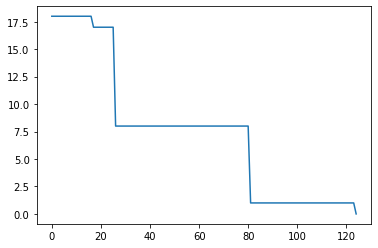

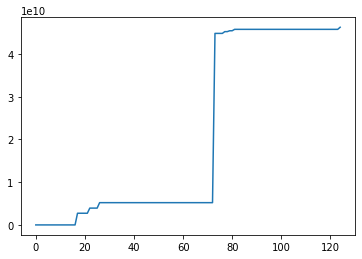

Total Revenue: 46275945340.59172
*********POPULATION 1***********
process time:951.1093067869999


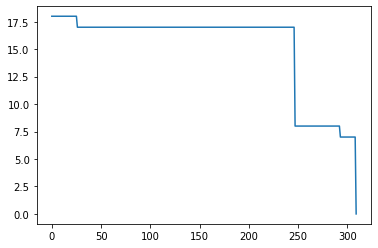

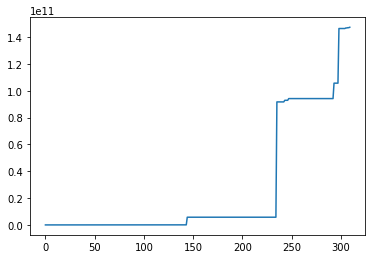

Total Revenue: 147323336506.80652
*********POPULATION 2***********
process time:952.561758526


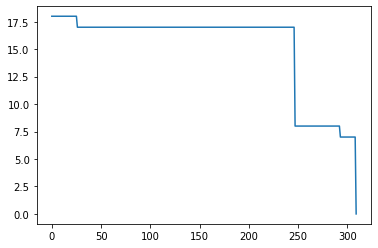

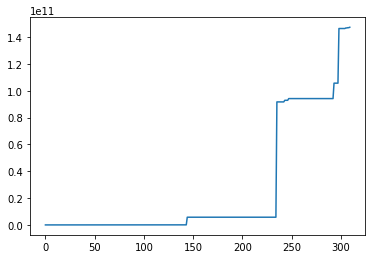

Total Revenue: 147323336506.80652
Initial Revenue: 147323336506.80652
*********POPULATION 0***********
process time:950.9926636149999


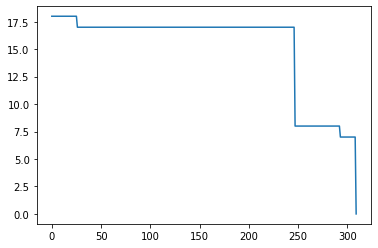

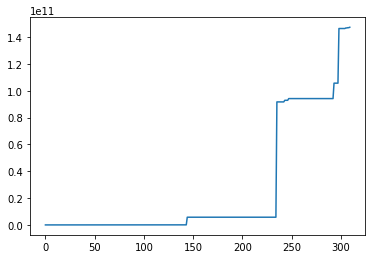

Total Revenue: 147323336506.80652
*********POPULATION 1***********
process time:970.9720158100004


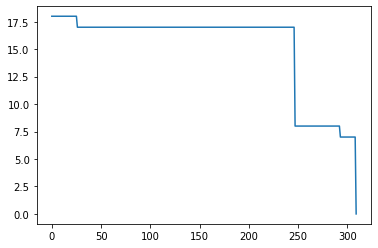

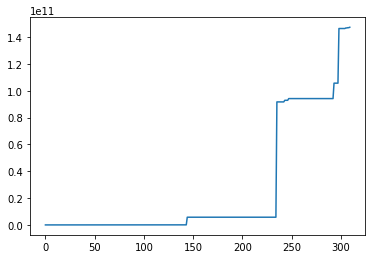

Total Revenue: 147323336506.80652
*********POPULATION 2***********
process time:983.786541124


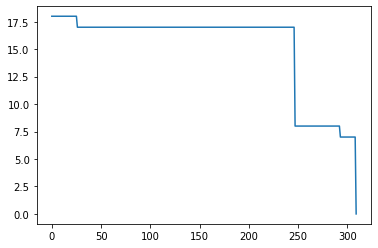

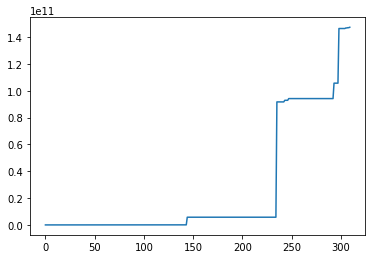

Total Revenue: 147323336506.80652
********************************************************
******************* GENERATION 0 **********************
********************************************************
iteration: 1 current best revenue: 147323336506.80652 overall best revenue: 147323336506.80652
*********POPULATION 0***********
process time:983.692016903


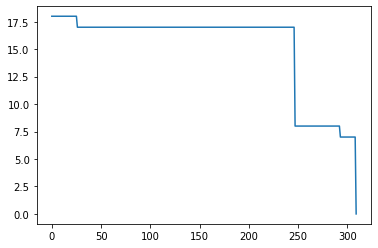

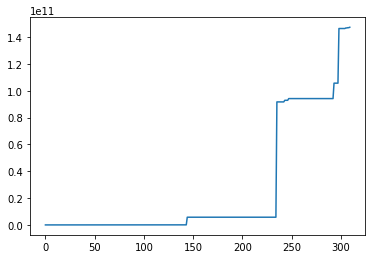

Total Revenue: 147323336506.80652
*********POPULATION 1***********
process time:960.4286761849999


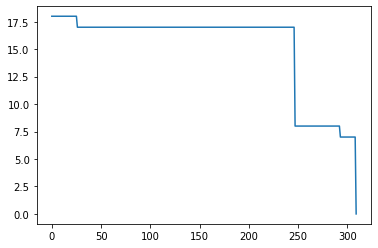

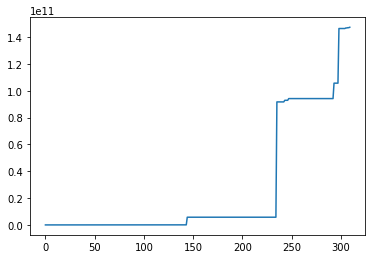

Total Revenue: 147323336506.80652
*********POPULATION 2***********
process time:951.8177554629992


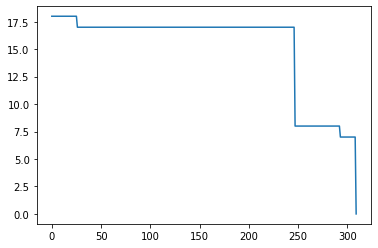

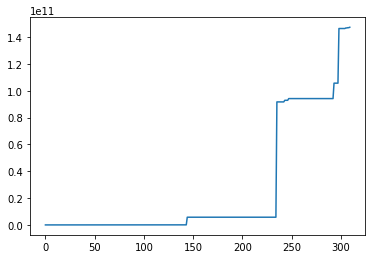

Total Revenue: 147323336506.80652
********************************************************
******************* GENERATION 1 **********************
********************************************************
iteration: 2 current best revenue: 147323336506.80652 overall best revenue: 147323336506.80652
Final distance: 147323336506.80652


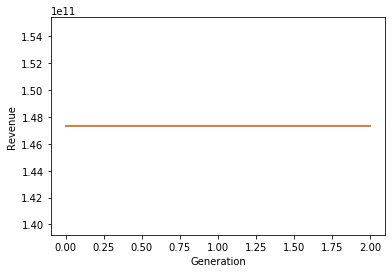

({'TL1': [Utama:Tanjung Perak,
   Pengumpul:Namlea,
   Pengumpul:Moa,
   Pengumpul:Namrole,
   Pengumpul:Dobo,
   Pengumpul:Namlea,
   Pengumpan:Buano,
   Pengumpan:Ambalau,
   Pengumpan:Adault/Lingat,
   Pengumpul:Kisar,
   Pengumpan:Kelimuri,
   Pengumpan:Marsela,
   Pengumpul:Namrole,
   Pengumpan:P.Geser,
   Pengumpan:Amahai,
   Pengumpan:Kelimoi,
   Pengumpan:Teon,
   Pengumpan:Arwala/Sutilirang,
   Pengumpan:Tepa,
   Pengumpul:Saumlaki,
   Pengumpan:Tifu,
   Pengumpan:Kobisadar,
   Pengumpan:Bebar,
   Pengumpul:Ambon,
   Pengumpan:Kelang,
   Pengumpan:Kroing,
   Pengumpul:Kisar,
   Pengumpan:Molu,
   Pengumpan:Ilwaki,
   Pengumpul:Moa],
  'TL2': [Utama:Makassar,
   Pengumpan:Tepa,
   Pengumpan:Weduar,
   Pengumpan:Ilwaki,
   Pengumpul:Tual,
   Pengumpul:Saumlaki,
   Pengumpul:Namlea,
   Pengumpan:Meror,
   Pengumpan:Gorom,
   Pengumpul:Namrole,
   Pengumpan:Jerol,
   Pengumpul:Moa,
   Pengumpul:Kisar,
   Pengumpan:Marsela,
   Pengumpul:Dobo,
   Pengumpan:Mun,
   Pengumpan:Adault/

In [63]:
bestRoute,best_route_overall = geneticAlgorithmPlot(ship_names, n_pop, elite_n, mutationRate, n_generation)

In [68]:
save_this = pop[0]

In [69]:
np.save('best_route_overall.npy', best_route_overall)
np.save('best_route_overall.npy', best_route_overall)

In [70]:
read_dictionary = np.load('best_routes.npy',allow_pickle='TRUE').item()
read_dictionary

{'TL1': [Utama:Tanjung Perak,
  Pengumpul:Moa,
  Pengumpul:Namlea,
  Pengumpan:Ambalau,
  Pengumpan:Adault/Lingat,
  Pengumpul:Dobo,
  Pengumpul:Kisar,
  Pengumpan:Kobisadar,
  Pengumpan:Kelang,
  Pengumpan:Kelimuri,
  Pengumpan:Kelimoi,
  Pengumpan:Tepa,
  Pengumpul:Namrole,
  Pengumpan:Teon,
  Pengumpan:Bebar,
  Pengumpul:Namlea,
  Pengumpul:Moa,
  Pengumpul:Ambon,
  Pengumpan:Tifu,
  Pengumpan:Buano,
  Pengumpan:P.Geser,
  Pengumpan:Ilwaki,
  Pengumpan:Marsela,
  Pengumpan:Molu,
  Pengumpul:Namrole,
  Pengumpul:Saumlaki,
  Pengumpan:Kroing,
  Pengumpan:Arwala/Sutilirang,
  Pengumpul:Kisar,
  Pengumpan:Amahai],
 'TL2': [Utama:Makassar,
  Pengumpan:Meror,
  Pengumpan:Ilwaki,
  Pengumpan:Arwala/Sutilirang,
  Pengumpan:Adault/Lingat,
  Pengumpan:P.Manawoka,
  Pengumpan:Tabarfane,
  Pengumpul:Moa,
  Pengumpan:Gorom,
  Pengumpan:Longgar,
  Pengumpan:Tepa,
  Pengumpul:Kisar,
  Pengumpan:Marsela,
  Pengumpan:Jerol,
  Pengumpul:Namrole,
  Pengumpan:Teon,
  Pengumpan:Mun,
  Pengumpan:Toyando,